In [1]:
import pandas as pd 
import numpy as np
from presidio_analyzer import AnalyzerEngine
from presidio_anonymizer import AnonymizerEngine
from presidio_analyzer import PatternRecognizer
from presidio_image_redactor import ImageRedactorEngine
from PIL import Image
from presidio_analyzer import Pattern

In [2]:
from typing import List, Optional, Dict, Union, Iterator, Iterable
import collections
from dataclasses import dataclass
import pprint

import pandas as pd

from presidio_analyzer import AnalyzerEngine, RecognizerResult
from presidio_anonymizer import AnonymizerEngine
from presidio_anonymizer.entities import EngineResult

### Calling Batch Analyzer from Presidio

In [9]:
#from https://microsoft.github.io/presidio/samples/python/batch_processing/
#uploading classes to use BatchAnalyzer from presidio

@dataclass
class DictAnalyzerResult:
    """Hold the analyzer results per value or list of values."""
    key: str
    value: Union[str, List[str]]
    recognizer_results: Union[List[RecognizerResult], List[List[RecognizerResult]]]


class BatchAnalyzerEngine(AnalyzerEngine):
    """
    Class inheriting from AnalyzerEngine and adds the funtionality to analyze lists or dictionaries.
    """
    
    def analyze_list(self, list_of_texts: Iterable[str], **kwargs) -> List[List[RecognizerResult]]:
        """
        Analyze an iterable of strings
        
        :param list_of_texts: An iterable containing strings to be analyzed.
        :param kwargs: Additional parameters for the `AnalyzerEngine.analyze` method.
        """
        
        list_results = []
        for text in list_of_texts:
            results = self.analyze(text=text, **kwargs) if isinstance(text, str) else []
            list_results.append(results)
        return list_results

    def analyze_dict(
     self, input_dict: Dict[str, Union[object, Iterable[object]]], **kwargs) -> Iterator[DictAnalyzerResult]:
        """
        Analyze a dictionary of keys (strings) and values (either object or Iterable[object]). 
        Non-string values are returned as is.

                :param input_dict: The input dictionary for analysis
        :param kwargs: Additional keyword arguments for the `AnalyzerEngine.analyze` method
        """
        
        for key, value in input_dict.items():
            if not value:
                results = []
            else:
                if isinstance(value, str):
                    results: List[RecognizerResult] = self.analyze(text=value, **kwargs)
                elif isinstance(value, collections.abc.Iterable):
                    results: List[List[RecognizerResult]] = self.analyze_list(
                                list_of_texts=value, 
                                **kwargs)
                else:
                    results = []
            yield DictAnalyzerResult(key=key, value=value, recognizer_results=results)


class BatchAnonymizerEngine(AnonymizerEngine):
    """
    Class inheriting from the AnonymizerEngine and adding additional functionality 
    for anonymizing lists or dictionaries.
    """
    
    def anonymize_list(
        self, 
        texts:List[str], 
        recognizer_results_list: List[List[RecognizerResult]], 
        **kwargs
    ) -> List[EngineResult]:
        """
        Anonymize a list of strings.
        
        :param texts: List containing the texts to be anonymized (original texts)
        :param recognizer_results_list: A list of lists of RecognizerResult, 
        the output of the AnalyzerEngine on each text in the list.
        :param kwargs: Additional kwargs for the `AnonymizerEngine.anonymize` method
        """
        return_list = []
        for text, recognizer_results in zip(texts, recognizer_results_list):
            if isinstance(text,str):
                res = self.anonymize(text=text,analyzer_results=recognizer_results,**kwargs)
                return_list.append(res.text)
            else:
                return_list.append(text)

        return return_list


    def anonymize_dict(self, analyzer_results: Iterator[DictAnalyzerResult],**kwargs) -> Dict[str, str]:

        """
        Anonymize values in a dictionary.
        
        :param analyzer_results: Iterator of `DictAnalyzerResult` 
        containing the output of the AnalyzerEngine.analyze_dict on the input text.
        :param kwargs: Additional kwargs for the `AnonymizerEngine.anonymize` method
        """
        
        return_dict = {}
        for result in analyzer_results:
            if isinstance(result.value, str):
                resp = self.anonymize(text=result.value, analyzer_results=result.recognizer_results, **kwargs)
                return_dict[result.key] = resp.text
            elif isinstance(result.value, collections.abc.Iterable):
                anonymize_respones = self.anonymize_list(texts=result.value,
                                                         recognizer_results_list=result.recognizer_results, 
                                                         **kwargs)
                return_dict[result.key] = anonymize_respones 
            else:
                return_dict[result.key] = result.value

        return return_dict            

## Analyzing and exploring Text dataset

In [10]:
df = pd.read_csv("pii_data.txt", sep="\t", index_col = 0).reset_index(drop = True) #uploading file

df_dict = df.to_dict(orient="list")

In [11]:
df.dtypes #types of data

ID                         int64
CREATED_BY                object
CREATED_ON                object
UPDATED_BY                object
UPDATED_ON                object
DELETED                    int64
DISABLED                   int64
ADDEDFROMUI                int64
UNIQUEKEY                 object
ISCURRENT                  int64
NAME                      object
OPTLOCKVER                 int64
VALID_FROM                object
VALID_TILL                object
INACTIVE                   int64
ISADMIN                    int64
LOCKED                     int64
PASSWORD                  object
USERNAME                  object
SUPERVISOR                 int64
FIRST_NAME                object
IS_MANAGER                 int64
LAST_NAME                 object
MANAGER                    int64
ASSET_ID                   int64
phone numbers              int64
Social Security number    object
DOB                       object
email                     object
address                   object
city      

In [12]:
df['zip'] = df['zip'].astype(str)#turning into string
df['phone numbers'] = df['phone numbers'].astype(str)#turning into string

In [13]:
df.dtypes

ID                         int64
CREATED_BY                object
CREATED_ON                object
UPDATED_BY                object
UPDATED_ON                object
DELETED                    int64
DISABLED                   int64
ADDEDFROMUI                int64
UNIQUEKEY                 object
ISCURRENT                  int64
NAME                      object
OPTLOCKVER                 int64
VALID_FROM                object
VALID_TILL                object
INACTIVE                   int64
ISADMIN                    int64
LOCKED                     int64
PASSWORD                  object
USERNAME                  object
SUPERVISOR                 int64
FIRST_NAME                object
IS_MANAGER                 int64
LAST_NAME                 object
MANAGER                    int64
ASSET_ID                   int64
phone numbers             object
Social Security number    object
DOB                       object
email                     object
address                   object
city      

In [14]:
df.describe(include='all')#describing the data

,ID,CREATED_BY,CREATED_ON,UPDATED_BY,UPDATED_ON,DELETED,DISABLED,ADDEDFROMUI,UNIQUEKEY,ISCURRENT,...,MANAGER,ASSET_ID,phone numbers,Social Security number,DOB,email,address,city,state,zip
count,999.000000,999,999,999,999,999.0,999.0,999.0,999,999.0,...,999.000000,999.0,999,999,999,999,999,999,999,999
unique,NaN,1,1,1,1,NaN,NaN,NaN,999,NaN,...,NaN,NaN,999,999,959,969,500,342,47,451
top,NaN,gladmin,12/10/2020 14:43,gladmin,12/10/2020 14:43,NaN,NaN,NaN,187d6ad09239b3a90a5ba5e3ab220336,NaN,...,NaN,NaN,5046219026,463-77-8900,3/27/1970,rcabrera@pth.com,3424 29th St Se,New York,CA,90248
freq,NaN,999,999,999,999,NaN,NaN,NaN,1,NaN,...,NaN,NaN,1,1,3,12,2,28,144,8
mean,501.406406,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,...,100045.305305,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,289.223338,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,...,27.724704,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2.000000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,...,100027.000000,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,251.500000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,...,100028.000000,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,501.000000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,...,100029.000000,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,750.500000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,...,100058.000000,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df['state'].unique()# unique states

array(['LA', 'MI', 'NJ', 'AK', 'OH', 'IL', 'CA', 'SD', 'MD', 'PA', 'NY',
       'TX', 'AZ', 'TN', 'WI', 'KS', 'NM', 'OR', 'FL', 'MN', 'MA', 'SC',
       'RI', 'CO', 'ID', 'NC', 'IN', 'WY', 'VA', 'HI', 'GA', 'AR', 'NV',
       'ME', 'WA', 'MS', 'CT', 'MO', 'NH', 'ND', 'MT', 'IA', 'OK', 'KY',
       'UT', 'NE', 'DC'], dtype=object)

In [16]:
df.shape#shape of data

(999, 33)

In [17]:
print(df.isnull().sum().sum())#finding null values
print(df.columns[df.isna().any()].tolist())# which columns have null values

132
['FIRST_NAME']


In [18]:
location_list = pd.read_csv("us_cities_states_counties.csv", sep = '|').reset_index(drop = True)#uploading csv file to use list of states
location_list.head()

,City,State short,State full,County,City alias
0,Holtsville,NY,New York,SUFFOLK,Internal Revenue Service
1,Holtsville,NY,New York,SUFFOLK,Holtsville
2,Adjuntas,PR,Puerto Rico,ADJUNTAS,URB San Joaquin
3,Adjuntas,PR,Puerto Rico,ADJUNTAS,Jard De Adjuntas
4,Adjuntas,PR,Puerto Rico,ADJUNTAS,Colinas Del Gigante


In [19]:
location_list['State short'].nunique()

61

### Making the Presidio model better

In [20]:
batch_analyzer = BatchAnalyzerEngine()#using BatchAnalyzer


# Adding zip code in the entity list. Make sure zip code is turned into a string for regex to work
zip_pattern = Pattern(name="zip_pattern",regex= '(\\b\\d{5}(?:\\-\\d{4})?\\b)', score = 0.5)
zip_recognizer = PatternRecognizer(supported_entity="ZIPCODE", 
                                    patterns = [zip_pattern], 
                                    context= ["zip","zipcode"])
batch_analyzer.registry.add_recognizer(zip_recognizer)


#Adding State
state_recognizer = PatternRecognizer(supported_entity="STATE",
                                        deny_list=list(location_list['State short'].dropna().unique()),
                                        context= ["state","address"])
batch_analyzer.registry.add_recognizer(state_recognizer)


#Adding List of Cities
city_recognizer = PatternRecognizer(supported_entity="CITY",
                                      deny_list=list(location_list['City'].dropna().unique()),
                                      context= ["city","address"])

batch_analyzer.registry.add_recognizer(city_recognizer)

#Adding Password
password_pattern = Pattern(name="password_pattern",regex= '^(?=.*?[A-Z])(?=.*?[a-z])(?=.*?[0-9])(?=.*?[#?!@$%^&*-]).{8,}$', score = 0.5)
password_recognizer = PatternRecognizer(supported_entity="PASSWORD", patterns = [password_pattern], context= ["password"])
batch_analyzer.registry.add_recognizer(password_recognizer)

### Using Batch Anonymizer on the dataset

In [21]:
df_dict = df.to_dict(orient="list")#datafram turned into dictionary

batch_anonymizertest = BatchAnonymizerEngine()#anonayizing the data 
analyzer_results = batch_analyzer.analyze_dict(df_dict, language="en")

anonymizer_results = batch_anonymizertest.anonymize_dict(analyzer_results)
scrubbed_df = pd.DataFrame(anonymizer_results)
scrubbed_df

,ID,CREATED_BY,CREATED_ON,UPDATED_BY,UPDATED_ON,DELETED,DISABLED,ADDEDFROMUI,UNIQUEKEY,ISCURRENT,...,MANAGER,ASSET_ID,phone numbers,Social Security number,DOB,email,address,city,state,zip
0,31,gladmin,<DATE_TIME>,gladmin,<DATE_TIME>,0,0,0,26d04379f776b97fb53dfe78ff146a95,0,...,100058,4,<DATE_TIME>,<US_SSN>,<DATE_TIME>,<EMAIL_ADDRESS>,6649 N <CITY> Gum St,<CITY>,<CITY>,<ZIPCODE>
1,32,gladmin,<DATE_TIME>,gladmin,<DATE_TIME>,0,0,0,75851ebf88dd7ce865d7ee7fb7dacb60,0,...,100029,4,<DATE_TIME>,<US_SSN>,<DATE_TIME>,<EMAIL_ADDRESS>,4 B <CITY> Blvd,<CITY>,<STATE>,<ZIPCODE>
2,33,gladmin,<DATE_TIME>,gladmin,<DATE_TIME>,0,0,0,f9dfe15f794e45809d16b9f1be261456,0,...,100028,4,<PHONE_NUMBER>,<US_SSN>,<DATE_TIME>,<EMAIL_ADDRESS>,<PASSWORD>,<CITY>,<STATE>,8014
3,34,gladmin,<DATE_TIME>,gladmin,<DATE_TIME>,0,0,0,6df9cd2ad41a761984736a084da09dd4,0,...,100028,4,<DATE_TIME>,<US_SSN>,<DATE_TIME>,<EMAIL_ADDRESS>,639 Main St,<CITY>,<STATE>,<ZIPCODE>
4,35,gladmin,<DATE_TIME>,gladmin,<DATE_TIME>,0,0,0,8de7f05a79c737e5951dc2867cd833bf,0,...,100029,4,<PHONE_NUMBER>,<US_SSN>,<DATE_TIME>,<EMAIL_ADDRESS>,34 <CITY> St,<CITY>,<STATE>,<ZIPCODE>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,967,gladmin,<DATE_TIME>,gladmin,<DATE_TIME>,0,0,0,b78f9eb5245bfd2b68bd142416e936d8,0,...,100058,4,<PHONE_NUMBER>,<US_SSN>,<DATE_TIME>,<EMAIL_ADDRESS>,<PASSWORD>,<CITY>,<STATE>,<ZIPCODE>
995,968,gladmin,<DATE_TIME>,gladmin,<DATE_TIME>,0,0,0,a49450f0671a9ec7aebad57032f2e191,0,...,100028,4,<PHONE_NUMBER>,<US_SSN>,<DATE_TIME>,<EMAIL_ADDRESS>,67 Rv Cent,<CITY>,<STATE>,<ZIPCODE>
996,969,gladmin,<DATE_TIME>,gladmin,<DATE_TIME>,0,0,0,afa74b90f534ac142764e342557240e3,0,...,100029,4,<PHONE_NUMBER>,<US_SSN>,<DATE_TIME>,<EMAIL_ADDRESS>,2 Sw Nyberg <LOCATION>,<CITY>,<STATE>,<ZIPCODE>
997,970,gladmin,<DATE_TIME>,gladmin,<DATE_TIME>,0,0,0,76332a8d2ba0f9998a939d21e463b9b7,0,...,100028,4,<PHONE_NUMBER>,<US_SSN>,<DATE_TIME>,<EMAIL_ADDRESS>,<ZIPCODE> E 15th St,<CITY>,<STATE>,<DATE_TIME>


### Using analyzer function on dataset

In [22]:
df_dict = df.to_dict(orient="list") #df being converted to a dictionary
analyzer_results = batch_analyzer.analyze_dict(df_dict, language="en")
analyzer_df = pd.DataFrame(analyzer_results) #converting into a dataframe
analyzer_df

,key,value,recognizer_results
0,ID,"[31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 4...","[[], [], [], [], [], [], [], [], [], [], [], [..."
1,CREATED_BY,"[gladmin, gladmin, gladmin, gladmin, gladmin, ...","[[], [], [], [], [], [], [], [], [], [], [], [..."
2,CREATED_ON,"[12/10/2020 14:43, 12/10/2020 14:43, 12/10/202...","[[type: DATE_TIME, start: 0, end: 16, score: 0..."
3,UPDATED_BY,"[gladmin, gladmin, gladmin, gladmin, gladmin, ...","[[], [], [], [], [], [], [], [], [], [], [], [..."
4,UPDATED_ON,"[12/10/2020 14:43, 12/10/2020 14:43, 12/10/202...","[[type: DATE_TIME, start: 0, end: 16, score: 0..."
5,DELETED,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[], [], [], [], [], [], [], [], [], [], [], [..."
6,DISABLED,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[], [], [], [], [], [], [], [], [], [], [], [..."
7,ADDEDFROMUI,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[], [], [], [], [], [], [], [], [], [], [], [..."
8,UNIQUEKEY,"[26d04379f776b97fb53dfe78ff146a95, 75851ebf88d...","[[], [], [], [], [], [type: LOCATION, start: 0..."
9,ISCURRENT,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[], [], [], [], [], [], [], [], [], [], [], [..."


In [23]:
presidio_df = pd.DataFrame(list(analyzer_df['recognizer_results']), analyzer_df['key']).reset_index()
presidio_df # converting readable dataset

,key,0,1,2,3,4,5,6,7,8,...,989,990,991,992,993,994,995,996,997,998
0,ID,[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
1,CREATED_BY,[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
2,CREATED_ON,"[type: DATE_TIME, start: 0, end: 16, score: 0.85]","[type: DATE_TIME, start: 0, end: 16, score: 0.85]","[type: DATE_TIME, start: 0, end: 16, score: 0.85]","[type: DATE_TIME, start: 0, end: 16, score: 0.85]","[type: DATE_TIME, start: 0, end: 16, score: 0.85]","[type: DATE_TIME, start: 0, end: 16, score: 0.85]","[type: DATE_TIME, start: 0, end: 16, score: 0.85]","[type: DATE_TIME, start: 0, end: 16, score: 0.85]","[type: DATE_TIME, start: 0, end: 16, score: 0.85]",...,"[type: DATE_TIME, start: 0, end: 16, score: 0.85]","[type: DATE_TIME, start: 0, end: 16, score: 0.85]","[type: DATE_TIME, start: 0, end: 16, score: 0.85]","[type: DATE_TIME, start: 0, end: 16, score: 0.85]","[type: DATE_TIME, start: 0, end: 16, score: 0.85]","[type: DATE_TIME, start: 0, end: 16, score: 0.85]","[type: DATE_TIME, start: 0, end: 16, score: 0.85]","[type: DATE_TIME, start: 0, end: 16, score: 0.85]","[type: DATE_TIME, start: 0, end: 16, score: 0.85]","[type: DATE_TIME, start: 0, end: 16, score: 0.85]"
3,UPDATED_BY,[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
4,UPDATED_ON,"[type: DATE_TIME, start: 0, end: 16, score: 0.85]","[type: DATE_TIME, start: 0, end: 16, score: 0.85]","[type: DATE_TIME, start: 0, end: 16, score: 0.85]","[type: DATE_TIME, start: 0, end: 16, score: 0.85]","[type: DATE_TIME, start: 0, end: 16, score: 0.85]","[type: DATE_TIME, start: 0, end: 16, score: 0.85]","[type: DATE_TIME, start: 0, end: 16, score: 0.85]","[type: DATE_TIME, start: 0, end: 16, score: 0.85]","[type: DATE_TIME, start: 0, end: 16, score: 0.85]",...,"[type: DATE_TIME, start: 0, end: 16, score: 0.85]","[type: DATE_TIME, start: 0, end: 16, score: 0.85]","[type: DATE_TIME, start: 0, end: 16, score: 0.85]","[type: DATE_TIME, start: 0, end: 16, score: 0.85]","[type: DATE_TIME, start: 0, end: 16, score: 0.85]","[type: DATE_TIME, start: 0, end: 16, score: 0.85]","[type: DATE_TIME, start: 0, end: 16, score: 0.85]","[type: DATE_TIME, start: 0, end: 16, score: 0.85]","[type: DATE_TIME, start: 0, end: 16, score: 0.85]","[type: DATE_TIME, start: 0, end: 16, score: 0.85]"
5,DELETED,[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
6,DISABLED,[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
7,ADDEDFROMUI,[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
8,UNIQUEKEY,[],[],[],[],[],"[type: LOCATION, start: 0, end: 32, score: 0.85]",[],[],[],...,[],[],[],[],[],[],[],[],[],[]
9,ISCURRENT,[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]


In [17]:
#analysing values within the address column
col = 29
print('PERSON:', str(analyzer_df['recognizer_results'][col]).count('PERSON'))
print('LOCATION:',str(analyzer_df['recognizer_results'][col]).count('LOCATION'))
print('DATE_TIME:',str(analyzer_df['recognizer_results'][col]).count('DATE_TIME'))
print('ZIP CODE:',str(analyzer_df['recognizer_results'][col]).count('ZIPCODE'))
print('STATE:',str(analyzer_df['recognizer_results'][col]).count('STATE'))
print('CITY:',str(analyzer_df['recognizer_results'][col]).count('CITY'))
print('PASSWORD:',str(analyzer_df['recognizer_results'][col]).count('PASSWORD'))
print('Empty []:', str(analyzer_df['recognizer_results'][col]).count('[]'))
print("Total Types:", str(analyzer_df['recognizer_results'][col]).count('type'))

PERSON: 162
LOCATION: 168
DATE_TIME: 74
ZIP CODE: 176
STATE: 0
CITY: 583
PASSWORD: 218
Empty []: 190
Total Types: 1387


In [18]:
#city
col = 30
print('PERSON:', str(analyzer_df['recognizer_results'][col]).count('PERSON'))
print('LOCATION:',str(analyzer_df['recognizer_results'][col]).count('LOCATION'))
print('DATE_TIME:',str(analyzer_df['recognizer_results'][col]).count('DATE_TIME'))
print('ZIP CODE:',str(analyzer_df['recognizer_results'][col]).count('ZIPCODE'))
print('STATE:',str(analyzer_df['recognizer_results'][col]).count('STATE'))
print('CITY:',str(analyzer_df['recognizer_results'][col]).count('CITY'))
print('PASSWORD:',str(analyzer_df['recognizer_results'][col]).count('PASSWORD'))
print('Empty []:', str(analyzer_df['recognizer_results'][col]).count('[]'))
print("Total Types:", str(analyzer_df['recognizer_results'][col]).count('type'))

PERSON: 104
LOCATION: 743
DATE_TIME: 0
ZIP CODE: 0
STATE: 0
CITY: 1025
PASSWORD: 0
Empty []: 0
Total Types: 1872


In [19]:
#state
col = 31
print('PERSON:', str(analyzer_df['recognizer_results'][col]).count('PERSON'))
print('LOCATION:',str(analyzer_df['recognizer_results'][col]).count('LOCATION'))
print('DATE_TIME:',str(analyzer_df['recognizer_results'][col]).count('DATE_TIME'))
print('ZIP CODE:',str(analyzer_df['recognizer_results'][col]).count('ZIPCODE'))
print('STATE:',str(analyzer_df['recognizer_results'][col]).count('STATE'))
print('CITY:',str(analyzer_df['recognizer_results'][col]).count('CITY'))
print('PASSWORD:',str(analyzer_df['recognizer_results'][col]).count('PASSWORD'))
print('Empty []:', str(analyzer_df['recognizer_results'][col]).count('[]'))
print("Total Types:", str(analyzer_df['recognizer_results'][col]).count('type'))

PERSON: 28
LOCATION: 521
DATE_TIME: 0
ZIP CODE: 0
STATE: 999
CITY: 20
PASSWORD: 0
Empty []: 0
Total Types: 1568


In [20]:
#zip code
col = 32
print('PERSON:', str(analyzer_df['recognizer_results'][col]).count('PERSON'))
print('LOCATION:',str(analyzer_df['recognizer_results'][col]).count('LOCATION'))
print('DATE_TIME:',str(analyzer_df['recognizer_results'][col]).count('DATE_TIME'))
print('ZIP CODE:',str(analyzer_df['recognizer_results'][col]).count('ZIPCODE'))
print('STATE:',str(analyzer_df['recognizer_results'][col]).count('STATE'))
print('PASSWORD:',str(analyzer_df['recognizer_results'][col]).count('PASSWORD'))
print('Empty []:', str(analyzer_df['recognizer_results'][col]).count('[]'))
print("Total Types:", str(analyzer_df['recognizer_results'][col]).count('type'))

PERSON: 20
LOCATION: 0
DATE_TIME: 336
ZIP CODE: 843
STATE: 0
PASSWORD: 0
Empty []: 94
Total Types: 1199


In [21]:
#password
col = 17
print('PERSON:', str(analyzer_df['recognizer_results'][col]).count('PERSON'))
print('LOCATION:',str(analyzer_df['recognizer_results'][col]).count('LOCATION'))
print('DATE_TIME:',str(analyzer_df['recognizer_results'][col]).count('DATE_TIME'))
print('ZIP CODE:',str(analyzer_df['recognizer_results'][col]).count('ZIPCODE'))
print('STATE:',str(analyzer_df['recognizer_results'][col]).count('STATE'))
print('PASSWORD:',str(analyzer_df['recognizer_results'][col]).count('PASSWORD'))
print('Empty []:', str(analyzer_df['recognizer_results'][col]).count('[]'))
print("Total Types:", str(analyzer_df['recognizer_results'][col]).count('type'))

PERSON: 0
LOCATION: 0
DATE_TIME: 0
ZIP CODE: 0
STATE: 0
PASSWORD: 999
Empty []: 0
Total Types: 1998


In [22]:
#username
col = 18
print('PERSON:', str(analyzer_df['recognizer_results'][col]).count('PERSON'))
print('LOCATION:',str(analyzer_df['recognizer_results'][col]).count('LOCATION'))
print('DATE_TIME:',str(analyzer_df['recognizer_results'][col]).count('DATE_TIME'))
print('ZIP CODE:',str(analyzer_df['recognizer_results'][col]).count('ZIPCODE'))
print('STATE:',str(analyzer_df['recognizer_results'][col]).count('STATE'))
print('PASSWORD:',str(analyzer_df['recognizer_results'][col]).count('PASSWORD'))
print('Empty []:', str(analyzer_df['recognizer_results'][col]).count('[]'))
print("Total Types:", str(analyzer_df['recognizer_results'][col]).count('type'))

PERSON: 147
LOCATION: 19
DATE_TIME: 26
ZIP CODE: 24
STATE: 0
PASSWORD: 0
Empty []: 757
Total Types: 277


In [23]:
#first name
col = 20
print('PERSON:', str(analyzer_df['recognizer_results'][col]).count('PERSON'))
print('LOCATION:',str(analyzer_df['recognizer_results'][col]).count('LOCATION'))
print('DATE_TIME:',str(analyzer_df['recognizer_results'][col]).count('DATE_TIME'))
print('ZIP CODE:',str(analyzer_df['recognizer_results'][col]).count('ZIPCODE'))
print('STATE:',str(analyzer_df['recognizer_results'][col]).count('STATE'))
print('PASSWORD:',str(analyzer_df['recognizer_results'][col]).count('PASSWORD'))
print('Empty []:', str(analyzer_df['recognizer_results'][col]).count('[]'))
print("Total Types:", str(analyzer_df['recognizer_results'][col]).count('type'))

PERSON: 717
LOCATION: 18
DATE_TIME: 2
ZIP CODE: 0
STATE: 0
PASSWORD: 0
Empty []: 225
Total Types: 1035


In [24]:
#last name
col = 22
print('PERSON:', str(analyzer_df['recognizer_results'][col]).count('PERSON'))
print('LOCATION:',str(analyzer_df['recognizer_results'][col]).count('LOCATION'))
print('DATE_TIME:',str(analyzer_df['recognizer_results'][col]).count('DATE_TIME'))
print('ZIP CODE:',str(analyzer_df['recognizer_results'][col]).count('ZIPCODE'))
print('STATE:',str(analyzer_df['recognizer_results'][col]).count('STATE'))
print('PASSWORD:',str(analyzer_df['recognizer_results'][col]).count('PASSWORD'))
print('Empty []:', str(analyzer_df['recognizer_results'][col]).count('[]'))
print("Total Types:", str(analyzer_df['recognizer_results'][col]).count('type'))

PERSON: 568
LOCATION: 40
DATE_TIME: 3
ZIP CODE: 0
STATE: 4
PASSWORD: 1
Empty []: 288
Total Types: 903


In [25]:
#phone number
col = 25
print('PERSON:', str(analyzer_df['recognizer_results'][col]).count('PERSON'))
print('LOCATION:',str(analyzer_df['recognizer_results'][col]).count('LOCATION'))
print('DATE_TIME:',str(analyzer_df['recognizer_results'][col]).count('DATE_TIME'))
print('ZIP CODE:',str(analyzer_df['recognizer_results'][col]).count('ZIPCODE'))
print('STATE:',str(analyzer_df['recognizer_results'][col]).count('STATE'))
print('PASSWORD:',str(analyzer_df['recognizer_results'][col]).count('PASSWORD'))
print('PHONE Number:',str(analyzer_df['recognizer_results'][col]).count('PHONE_NUMBER'))
print('Empty []:', str(analyzer_df['recognizer_results'][col]).count('[]'))
print("Total Types:", str(analyzer_df['recognizer_results'][col]).count('type'))

PERSON: 12
LOCATION: 0
DATE_TIME: 327
ZIP CODE: 0
STATE: 0
PASSWORD: 0
PHONE Number: 999
Empty []: 0
Total Types: 4236


## Using presidio on other types of files

#### Reading from csv

In [147]:
#from csv files
csv = pd.read_csv('pii_csv.csv')
csv = csv.astype(str).replace('nan',np.nan)
df_dict_csv = csv.to_dict(orient="list") #df being converted to a dictionary
analyzer_results_csv = batch_analyzer.analyze_dict(df_dict_csv, language="en")
analyzer_df_csv = pd.DataFrame(analyzer_results_csv) #converting into a dataframe
analyzer_df_csv

,key,value,recognizer_results
0,Unnamed: 0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[], [], [], [], [], [], [], [], [], [], [], [..."
1,ID,"[31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 4...","[[], [], [], [], [], [], [], [], [], [], [], [..."
2,CREATED_BY,"[gladmin, gladmin, gladmin, gladmin, gladmin, ...","[[], [], [], [], [], [], [], [], [], [], [], [..."
3,CREATED_ON,"[12/10/2020 14:43, 12/10/2020 14:43, 12/10/202...","[[type: DATE_TIME, start: 0, end: 16, score: 0..."
4,UPDATED_BY,"[gladmin, gladmin, gladmin, gladmin, gladmin, ...","[[], [], [], [], [], [], [], [], [], [], [], [..."
5,UPDATED_ON,"[12/10/2020 14:43, 12/10/2020 14:43, 12/10/202...","[[type: DATE_TIME, start: 0, end: 16, score: 0..."
6,DELETED,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[], [], [], [], [], [], [], [], [], [], [], [..."
7,DISABLED,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[], [], [], [], [], [], [], [], [], [], [], [..."
8,ADDEDFROMUI,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[], [], [], [], [], [], [], [], [], [], [], [..."
9,UNIQUEKEY,"[26d04379f776b97fb53dfe78ff146a95, 75851ebf88d...","[[], [], [], [], [], [type: LOCATION, start: 0..."


#### Reading from Excel

In [152]:
#from excel file
from pandas import read_excel
xlsx = pd.read_excel('pii_excel.xlsx', engine = 'openpyxl')
xlsx = xlsx.astype(str).replace('nan',np.nan)
df_dict_xlsx = xlsx.to_dict(orient="list") #df being converted to a dictionary
analyzer_results_xlsx = batch_analyzer.analyze_dict(df_dict_xlsx, language="en")
analyzer_df_xlsx = pd.DataFrame(analyzer_results_xlsx) #converting into a dataframe
analyzer_df_xlsx

,key,value,recognizer_results
0,Unnamed: 0,"[101, 102, 103, 104, 105, 106, 107, 108, 109, ...","[[], [], [], [], [], [], [], [], [], [], [], [..."
1,ID,"[75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 8...","[[], [], [], [], [], [], [], [], [], [], [], [..."
2,CREATED_BY,"[gladmin, gladmin, gladmin, gladmin, gladmin, ...","[[], [], [], [], [], [], [], [], [], [], [], [..."
3,CREATED_ON,"[12/10/2020 14:43, 12/10/2020 14:43, 12/10/202...","[[type: DATE_TIME, start: 0, end: 16, score: 0..."
4,UPDATED_BY,"[gladmin, gladmin, gladmin, gladmin, gladmin, ...","[[], [], [], [], [], [], [], [], [], [], [], [..."
5,UPDATED_ON,"[12/10/2020 14:43, 12/10/2020 14:43, 12/10/202...","[[type: DATE_TIME, start: 0, end: 16, score: 0..."
6,DELETED,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[], [], [], [], [], [], [], [], [], [], [], [..."
7,DISABLED,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[], [], [], [], [], [], [], [], [], [], [], [..."
8,ADDEDFROMUI,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[], [], [], [], [], [], [], [], [], [], [], [..."
9,UNIQUEKEY,"[10a0891a4321de0d9dd5fe7905ae0367, 9ba2868ab16...","[[], [], [], [], [], [type: PERSON, start: 0, ..."


#### Reading from PDF

In [6]:
#pdf turned into a jpeg and then jpeg is being read

# import module
from pdf2image import convert_from_path
 
 
# Store Pdf with convert_from_path function
images = convert_from_path('s_pii_pdf.pdf')
 
for i in range(len(images)):
   
      # Save pages as images in the pdf
    images[i].save('page'+ str(i) +'.jpg', 'JPEG')

img_pdf = Image.open("page0.jpg")
img_pdf = img_pdf.convert('RGBA')

result_pdf = pytesseract.image_to_string(img_pdf)
print(result_pdf)

‘BDINIOS ENUBASY |/BUE}U| 84} 0} peysiusny Huleg si uOIFeWWOjU! SIU,
“UINJOY XBL TWHAGSS S,eeAo;dwz YM Pel4 og O1—g AdoD

hTOe¢ xe, pe oem OTM

B9|AUES ENuUsASy [eWe}U|—Aunseel| oy} Jo JUeWedeg

000‘0S Ses‘l 0000S SEs
‘oy0 ‘sdy ‘seBem 2007 BE] xe} BWODU!9}BIS 2} | ‘d10 ‘sdyy ‘seBem oyeIS QL Jequunu q/ eye}s sueAojdw3 aS SE
@pod |Z puke sseuppe s,eeAo|dy 4

9SvEZ Vd ‘asia aseymAuy
je8S WF Eel
joq) = yeuer

eweu se] Jelyul pue eweu jsiy s,eeAo|dwy 8

sieued e120 ywepueded Ob ee. aly Jequinu jo2uog Pp

sdk perecoly 8 sd Ayunoes je00g 2 SVETL Wd ‘eseymAuy
00°SeZ 00°000‘0S JO91}S Ue ESL

PIOYUYM Xe} SILOIPS|N 9 sdy pue se6em eseoipey) ¢ Auedwog big oul

00°00L‘€ 00°000‘0S
9@P0d IZ pure ‘sseippe ‘eweu sjeAojdwy 9

pleyyym xe} Aynoes |e1I90$_% sebem Aqunoes [2100S

ae 00'00S'8+ Sreeze-Lt
(NI3) 4equinu uoHeoynUep! JeAojdWA q

PleyyyM xe} BWOdUI [e1epe4 Z uolesuadwwod Jayjo ‘sdy ‘sebem_ 4

"Sar 8000-S?Slt “ON EWO | \—
ress, TEED wn OST

J OYSGEM SUI 9U} JISIA

 



#### Reading from jpeg

In [3]:
# adds image processing capabilities
#reading image
from PIL import Image
import sys
import os

# will convert the image to text string
import pytesseract
img = Image.open("s_pii_jpg.jpg")
img = img.convert('RGBA')

result = pytesseract.image_to_string(img)
print(result)

 

 
  

‘a Employee's social security number
12 789

b Employer identification number (EIN) 11-2233445

  

Safe, accurate,
OMB No. 1545-0008 FAST! Use

 

¢ Employer's name, address, and ZIP code

The Big Company
123 Main Street
Anywhere, PA 12345

3 Social security wages

+ file
1 Wages, tips, other compensation ‘2 Federal income tax withheld
48,500.00 6,835.00

Visit the IRS website at
www.irs.govlefile

    
   

4 Social security tax withheld

 

50,000.00 3,100.00
5 Medicare wages and tips © Medicare tax withheld
50,000.00 725.00

 

7 Social security tips

8 Allocated tips

 

10 Dependent care benefits

 

f Employee’s address and ZIP code

 

 

 

 

 

 

 

 

 

 

 

 

d Control number At B2 9
e Employee's first name and initial Last name Suff.| 11 Nonqualified plans a See instructions for box 12
JaneA DOE == EY a” —
123 Elm Street cl fx  |£DD] — 1,000.00
Anywhere Else, PA 23456 14 Other ie
:P 4,800.00
12d

 

 

 

 

 

 

15 State 16 State wages, tips, etc.

Employer

## Using Presidio to read images

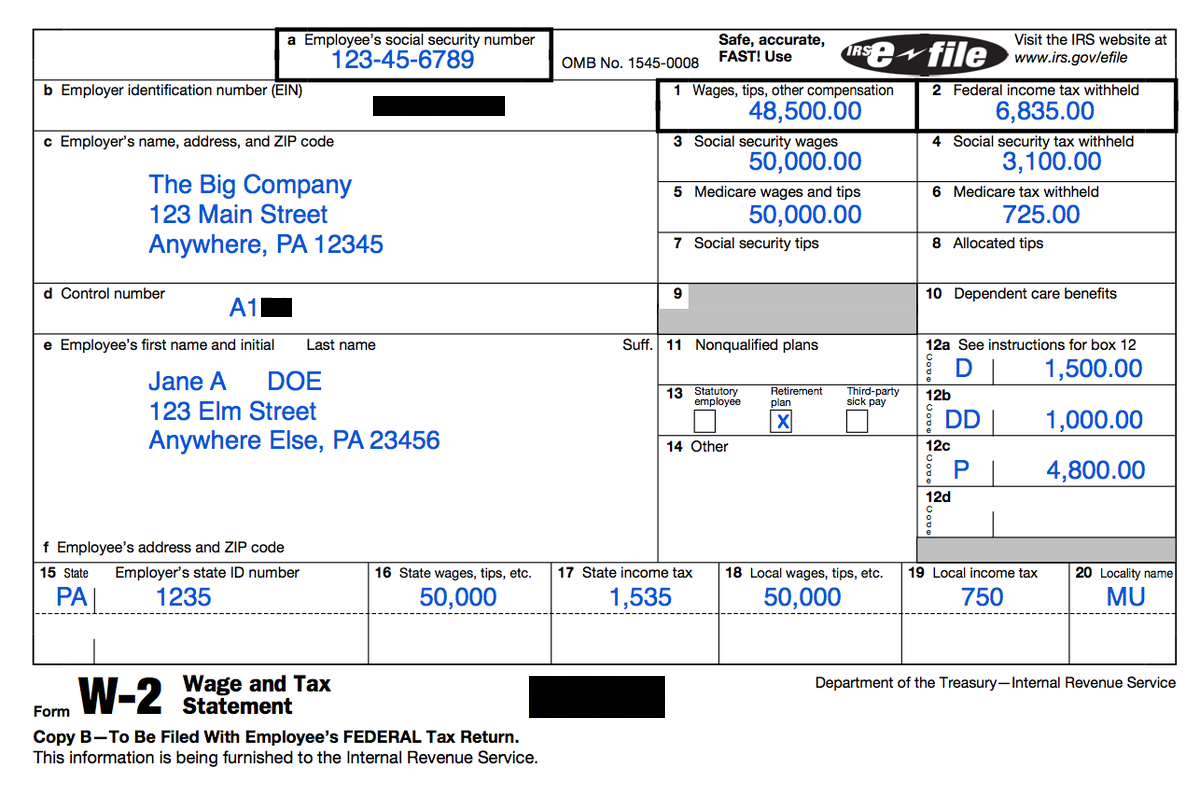

In [4]:
#Shows better result when we use non-passport image
#this is showing png file
from presidio_image_redactor import ImageRedactorEngine
from PIL import Image
path_to_image_file = 's_pii_png.png'

image = Image.open(path_to_image_file)

redactor = ImageRedactorEngine()
redactor.redact(image=image)

In [4]:
#actual result from reading the image file
import pandas as pd
from presidio_image_redactor import ImageAnalyzerEngine
image_analyzer = ImageAnalyzerEngine()

result_png = image_analyzer.analyze(image=image)
#image_analyzer = ImagePiiVerifyEngine() #to see the result of the analysis
#result_pdf = image_analyzer.verify(image=img_pdf) #to see the result of the analysis
pd.DataFrame(result_png)

,0
0,"type: US_SSN, start: 112, end: 123, score: 0.5"
1,"type: DATE_TIME, start: 132, end: 141, score: ..."
2,"type: US_DRIVER_LICENSE, start: 247, end: 254,..."
3,"type: PERSON, start: 406, end: 410, score: 0.85"
4,"type: US_DRIVER_LICENSE, start: 406, end: 410,..."
5,"type: PHONE_NUMBER, start: 484, end: 496, scor..."
6,"type: PHONE_NUMBER, start: 484, end: 496, scor..."
7,"type: PHONE_NUMBER, start: 484, end: 496, scor..."
8,"type: LOCATION, start: 509, end: 517, score: 0.85"
9,"type: LOCATION, start: 509, end: 517, score: 0.85"


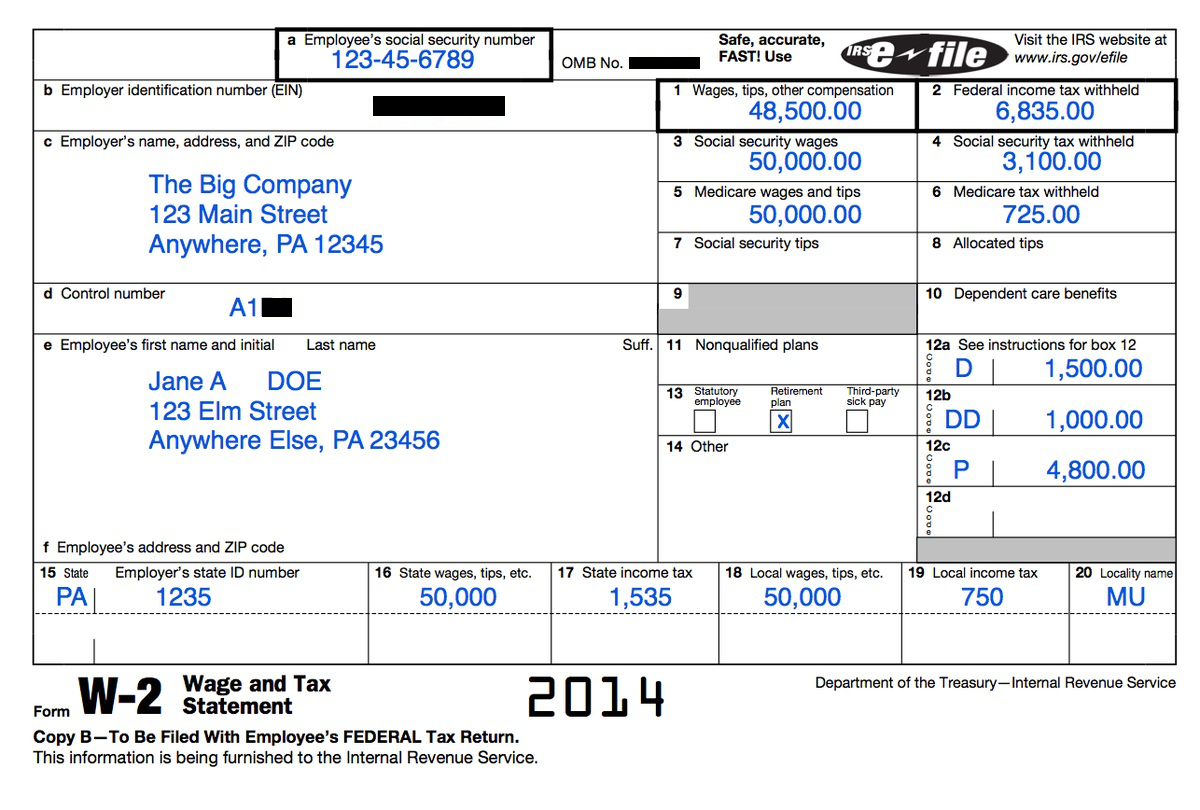

In [5]:
#this is showing jpg file
from presidio_image_redactor import ImageRedactorEngine
from PIL import Image

path_to_image_file = 's_pii_jpg.jpg'# insert your W2

image = Image.open(path_to_image_file)

redactor = ImageRedactorEngine()
redactor.redact(image=image)

In [6]:
import pandas as pd
from presidio_image_redactor import ImageAnalyzerEngine
image_analyzer = ImageAnalyzerEngine()

result_jpg = image_analyzer.analyze(image=image)
#image_analyzer = ImagePiiVerifyEngine() #to see the result of the analysis
#result_pdf = image_analyzer.verify(image=img_pdf) #to see the result of the analysis
pd.DataFrame(result_jpg)

,0
0,"type: US_SSN, start: 58, end: 69, score: 0.85"
1,"type: DATE_TIME, start: 78, end: 87, score: 0.85"
2,"type: US_DRIVER_LICENSE, start: 196, end: 203,..."
3,"type: PERSON, start: 344, end: 349, score: 0.85"
4,"type: PERSON, start: 353, end: 362, score: 0.85"
5,"type: PERSON, start: 353, end: 362, score: 0.85"
6,"type: LOCATION, start: 528, end: 536, score: 0.85"
7,"type: LOCATION, start: 528, end: 536, score: 0.85"
8,"type: PERSON, start: 645, end: 657, score: 0.85"
9,"type: PERSON, start: 645, end: 657, score: 0.85"


## Training user name data using NER model from Spacy

In [46]:
#creating dataset for SPACY model
l1 = []
l2 = []

for i in range(0,len(df['USERNAME'])):
    l1.append(df['USERNAME'][i])

    l2.append({'entities':[(0, len(df['USERNAME'][i]), 'USERNAME')]})

train_data = list(zip(l1,l2))
train_data

[('HTHERRES', {'entities': [(0, 8, 'USERNAME')]}),
 ('MPHILLION', {'entities': [(0, 9, 'USERNAME')]}),
 ('JNORI', {'entities': [(0, 5, 'USERNAME')]}),
 ('RTARNOWSKI', {'entities': [(0, 10, 'USERNAME')]}),
 ('BKUWABARA', {'entities': [(0, 9, 'USERNAME')]}),
 ('LSOBERING', {'entities': [(0, 9, 'USERNAME')]}),
 ('MAYER-21', {'entities': [(0, 8, 'USERNAME')]}),
 ('RJARCHE', {'entities': [(0, 7, 'USERNAME')]}),
 ('RCF_MGRASS', {'entities': [(0, 10, 'USERNAME')]}),
 ('EBEAL', {'entities': [(0, 5, 'USERNAME')]}),
 ('P25099417', {'entities': [(0, 9, 'USERNAME')]}),
 ('CGALDES', {'entities': [(0, 7, 'USERNAME')]}),
 ('HHSIEH', {'entities': [(0, 6, 'USERNAME')]}),
 ('EKLOPP', {'entities': [(0, 6, 'USERNAME')]}),
 ('SMURRAY', {'entities': [(0, 7, 'USERNAME')]}),
 ('EMASKELL', {'entities': [(0, 8, 'USERNAME')]}),
 ('CMR-02', {'entities': [(0, 6, 'USERNAME')]}),
 ('JCORMIER', {'entities': [(0, 8, 'USERNAME')]}),
 ('BDILION', {'entities': [(0, 7, 'USERNAME')]}),
 ('GKRMPOTIC', {'entities': [(0, 9, '

In [47]:
# Import and load the spacy model
import spacy
from spacy.training import Example
nlp=spacy.load("en_core_web_md")  #uploading existing spacy model

# Getting the ner component
ner=nlp.get_pipe('ner')

In [48]:
# New label to add
LABEL = "USERNAME"

# Add the new label to ner
ner.add_label(LABEL)

# Resume training
optimizer = nlp.resume_training()
move_names = list(ner.move_names)

# List of pipes you want to train
pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]

# List of pipes which should remain unaffected in training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]

In [49]:
move_names

['B-ORG',
 'B-DATE',
 'B-PERSON',
 'B-GPE',
 'B-MONEY',
 'B-CARDINAL',
 'B-NORP',
 'B-PERCENT',
 'B-WORK_OF_ART',
 'B-LOC',
 'B-TIME',
 'B-QUANTITY',
 'B-FAC',
 'B-EVENT',
 'B-ORDINAL',
 'B-PRODUCT',
 'B-LAW',
 'B-LANGUAGE',
 'I-ORG',
 'I-DATE',
 'I-PERSON',
 'I-GPE',
 'I-MONEY',
 'I-CARDINAL',
 'I-NORP',
 'I-PERCENT',
 'I-WORK_OF_ART',
 'I-LOC',
 'I-TIME',
 'I-QUANTITY',
 'I-FAC',
 'I-EVENT',
 'I-ORDINAL',
 'I-PRODUCT',
 'I-LAW',
 'I-LANGUAGE',
 'L-ORG',
 'L-DATE',
 'L-PERSON',
 'L-GPE',
 'L-MONEY',
 'L-CARDINAL',
 'L-NORP',
 'L-PERCENT',
 'L-WORK_OF_ART',
 'L-LOC',
 'L-TIME',
 'L-QUANTITY',
 'L-FAC',
 'L-EVENT',
 'L-ORDINAL',
 'L-PRODUCT',
 'L-LAW',
 'L-LANGUAGE',
 'U-ORG',
 'U-DATE',
 'U-PERSON',
 'U-GPE',
 'U-MONEY',
 'U-CARDINAL',
 'U-NORP',
 'U-PERCENT',
 'U-WORK_OF_ART',
 'U-LOC',
 'U-TIME',
 'U-QUANTITY',
 'U-FAC',
 'U-EVENT',
 'U-ORDINAL',
 'U-PRODUCT',
 'U-LAW',
 'U-LANGUAGE',
 'O',
 'B-USERNAME',
 'I-USERNAME',
 'L-USERNAME',
 'U-USERNAME']

In [50]:
# Importing requirements
from spacy.util import minibatch, compounding
import random

# Begin training by disabling other pipeline components
with nlp.disable_pipes(*other_pipes) :

  sizes = compounding(1.0, 4.0, 1.001)
  # Training for 30 iterations     
  for itn in range(30):
    # shuffle examples before training
    random.shuffle(train_data)
    # batch up the examples using spaCy's minibatch
    batches = minibatch(train_data, size=sizes)
    # ictionary to store losses
    losses = {}
    for batch in batches:
      texts, annotations = zip(*batch)
      # Calling update() over the iteration
      
      example = []
      # Update the model with iterating each text
      for i in range(len(texts)):
          doc = nlp.make_doc(texts[i])
          example.append(Example.from_dict(doc, annotations[i]))


      # Update the model
      nlp.update(example, sgd=optimizer, drop=0.35, losses=losses)

      

      #nlp.update(texts, annotations, sgd=optimizer, drop=0.35, losses=losses)
      print("Losses", losses)

Losses {'ner': 1.2764477729797363}
Losses {'ner': 2.4810811281204224}
Losses {'ner': 3.722582459449768}
Losses {'ner': 5.02884829044342}
Losses {'ner': 6.7750160694122314}
Losses {'ner': 8.055089473724365}
Losses {'ner': 9.418298482894897}
Losses {'ner': 10.45362663269043}
Losses {'ner': 11.870886445045471}
Losses {'ner': 13.062049388885498}
Losses {'ner': 14.16562044620514}
Losses {'ner': 15.721896767616272}
Losses {'ner': 17.557046055793762}
Losses {'ner': 18.623618483543396}
Losses {'ner': 20.112812876701355}
Losses {'ner': 21.64286506175995}
Losses {'ner': 23.226527094841003}
Losses {'ner': 24.39169204235077}
Losses {'ner': 25.94796359539032}
Losses {'ner': 27.335843205451965}
Losses {'ner': 28.7728453874588}
Losses {'ner': 30.18040120601654}
Losses {'ner': 31.561042070388794}
Losses {'ner': 33.142163038253784}
Losses {'ner': 34.308313846588135}
Losses {'ner': 35.25140595436096}
Losses {'ner': 36.491832852363586}
Losses {'ner': 37.37284600734711}
Losses {'ner': 38.4071729183197}
Lo

In [51]:
# testing with a Uername
test_text = "PBALL"
doc = nlp(test_text)
print("Entities in '%s'" % test_text)
for ent in doc.ents:
  print(ent)

Entities in 'PBALL'
PBALL


In [52]:
# Output directory
from pathlib import Path
output_dir=Path('/Users/priankaball/Desktop/MachineLearning/Final_Project/testmodel/')

# Saving the model to the output directory
if not output_dir.exists():
  output_dir.mkdir()
nlp.meta['name'] = 'my_ner'  # rename model
nlp.to_disk(output_dir)
print("Saved model to", output_dir)

# Loading the model from the directory
print("Loading from", output_dir)
nlp2 = spacy.load(output_dir) # loading model
assert nlp2.get_pipe("ner").move_names == move_names
doc2 = nlp2(' My name is Prianka. My passwords in 6668927267839. My username is PRIPRI')
for ent in doc2.ents:
  print(ent.label_, ent.text)

Saved model to /Users/priankaball/Desktop/MachineLearning/Final_Project/testmodel
Loading from /Users/priankaball/Desktop/MachineLearning/Final_Project/testmodel
USERNAME name is
USERNAME Prianka.
USERNAME My passwords in
USERNAME 6668927267839.
USERNAME is
USERNAME PRIPRI


In [53]:
move_names

['B-ORG',
 'B-DATE',
 'B-PERSON',
 'B-GPE',
 'B-MONEY',
 'B-CARDINAL',
 'B-NORP',
 'B-PERCENT',
 'B-WORK_OF_ART',
 'B-LOC',
 'B-TIME',
 'B-QUANTITY',
 'B-FAC',
 'B-EVENT',
 'B-ORDINAL',
 'B-PRODUCT',
 'B-LAW',
 'B-LANGUAGE',
 'I-ORG',
 'I-DATE',
 'I-PERSON',
 'I-GPE',
 'I-MONEY',
 'I-CARDINAL',
 'I-NORP',
 'I-PERCENT',
 'I-WORK_OF_ART',
 'I-LOC',
 'I-TIME',
 'I-QUANTITY',
 'I-FAC',
 'I-EVENT',
 'I-ORDINAL',
 'I-PRODUCT',
 'I-LAW',
 'I-LANGUAGE',
 'L-ORG',
 'L-DATE',
 'L-PERSON',
 'L-GPE',
 'L-MONEY',
 'L-CARDINAL',
 'L-NORP',
 'L-PERCENT',
 'L-WORK_OF_ART',
 'L-LOC',
 'L-TIME',
 'L-QUANTITY',
 'L-FAC',
 'L-EVENT',
 'L-ORDINAL',
 'L-PRODUCT',
 'L-LAW',
 'L-LANGUAGE',
 'U-ORG',
 'U-DATE',
 'U-PERSON',
 'U-GPE',
 'U-MONEY',
 'U-CARDINAL',
 'U-NORP',
 'U-PERCENT',
 'U-WORK_OF_ART',
 'U-LOC',
 'U-TIME',
 'U-QUANTITY',
 'U-FAC',
 'U-EVENT',
 'U-ORDINAL',
 'U-PRODUCT',
 'U-LAW',
 'U-LANGUAGE',
 'O',
 'B-USERNAME',
 'I-USERNAME',
 'L-USERNAME',
 'U-USERNAME']

In [54]:
doc2 = nlp2('SAM')
for ent in doc2.ents:
  print(ent.label_, ent.text)

USERNAME SAM


The NER model does not give the best result so we decided not to incorporate it. 